# Write and Optimize a Circuit

The [Bernstein Vazirani](https://en.wikipedia.org/wiki/Bernstein%E2%80%93Vazirani_algorithm) algorithm is one of the first quantum algorithms. The implementation of the algorithm is based on a secret string $a$  which is used to compute the function 
$f(x)=ax \oplus b$. Assume, for the purpose of this exercise, that $b=0$. The strings $x$ and $a$ are $n$ bits wide. The value $f(x)$ is computed as $f(x)=\sum a_i \cap x_i \,mod\, 2$ where $\cap$ is the [Boolean AND](https://en.wikipedia.org/wiki/Logical_conjunction) operation and the sum is [modulo 2](https://en.wikipedia.org/wiki/Modular_arithmetic).

**Note:** Consider the circuit non-configurable with respect to ancillae. This means, the value of $a$ is not input on wires.

**Note:** Use Google Cirq, because it has a more friendlier API: [Cirq](https://github.com/quantumlib/Cirq) 

**Note:** Only Python at all steps.

## 1. Compilation

Write a method that generates a circuit for a parameter $n$ and a string $a$. For example, the following call `bernstein_vazirani(3, "101")` generates a 4-qubit circuit that uses the `101` string as a secret when building the oracle.

In [28]:
!pip install --quiet cirq

In [29]:
import cirq

def bernstein_vazirani(n, secret):
    # n - number of bits
    # secret - the bit string called 'a' in some of the algorithm descriptions
    # Returns a n+1 qubit circuit, where the (n+1)-th qubit is for phase kickback
    # The data type does not matter, but it would be easier to use the Cirq/Qiskit
    # circuit data types
  
    circ = cirq.Circuit()
    qs = cirq.LineQubit.range(n+1)
    
    circ.append([cirq.H(qi) for qi in qs])
    circ.append([cirq.CX(qs[i], qs[n]) for i in range(n) if secret[i] == '1'])
    circ.append([cirq.H(qi) for qi in qs])

    return circ

## 2. Optimization

One of the simplest circuit identities is the fact that a sequence of two Hadamard gates cancel, and that the direction of a CNOT can be flipped by using Hadamards.

template 1 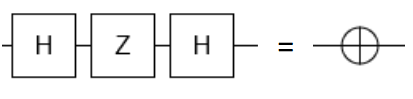


template 2  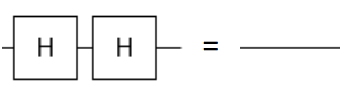

template 3 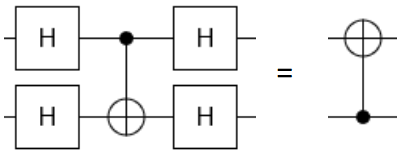

template 4 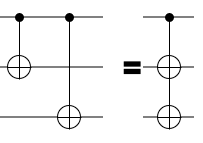

Write a `optimize_bv` method that optimizes the circuit from `bernstein_vazirani` by performing the following sequence of operations (no need to implement a heuristic):
* Apply Template 1: Replace the sequence HZH with an X gate where necessary.
* Apply Template 2: Cancel adjacent Hadamard gates.
* Apply Template 3: Invert the direction of all CNOT gates in the circuit.
* Apply Template 4: CNOTs with the same control and different target can be joined into a single CNOT operation having single controll and different targets (note: this is not a Toffoli gate)


**Note: You are not required to develop a general heuristic that works for any circuit. Your heuristic is perfectly fine if it works only for the Bernstein-Vazirani circuits.**

**Note: Templates can be applied in both directions (right->left, left->right). For example, two Hadamards may be inserted for the purpose of applying template 3.**

In [30]:
class CNNOT(cirq.Gate):
    def __init__(self, n: int):
        super(CNNOT, self)
        self.n = n

    def num_qubits(self):
        return 1 + self.n

    def _decompose_(self, qubits):
        control = qubits[0]
        targets = qubits[1:]

        return [cirq.CNOT(control, target) for target in targets]

    def _circuit_diagram_info_(self, args):
        return ["@"] + ["X" for _ in range(self.n)]

def optimize_bv(n, bv_circuit):
  
    # n - number of bits
    # bv_circuit - a quantum circuit, in this case a bernstein_vazirani circuit

    # just to initialize the return value
    opt_circuit = bv_circuit
  
    def merge_func1(op1: cirq.Operation, op2: cirq.Operation) -> cirq.Operation:
        if op1.gate == cirq.H and op2.gate == cirq.H and op1.qubits == op2.qubits:
            return cirq.IdentityGate(1)(op1.qubits[0])
        return None
    
    
    def map_func1(op: cirq.Operation, _: int) -> cirq.OP_TREE:
        if op.gate == cirq.I:
            pass
        else:
            yield op
            
    def map_func2(op: cirq.Operation, _: int) -> cirq.OP_TREE:
        if op.gate == cirq.CX:
            yield cirq.H(op.qubits[0])
            yield cirq.H(op.qubits[1])
            yield cirq.CX(op.qubits[1], op.qubits[0])
            yield cirq.H(op.qubits[0])
            yield cirq.H(op.qubits[1])
            
        else:
            yield op

    def merge_func2(m1: cirq.Moment, m2: cirq.Moment) -> cirq.Operation:
        op1 = m1.operations[0]
        op2 = m2.operations[0]
        if ((isinstance(op1.gate, CNNOT) or isinstance(op1.gate, cirq.CX.__class__)) and isinstance(op2.gate, cirq.CX.__class__)):
            control = op1.qubits[0]
            targets = op1.qubits[1:] + op2.qubits[1:]
            ncnot = CNNOT(len(op1.qubits))
            return cirq.Moment(ncnot.on(control, *targets))
        return None

    qc = cirq.map_operations_and_unroll(opt_circuit, map_func2)
    qc = cirq.merge_operations(qc, merge_func1)
    qc = cirq.map_operations_and_unroll(qc, map_func1)
    qc = cirq.merge_moments(qc, merge_func2)
    return qc

## 3. Export

A circuit should be exportable in a format that is compatible with a quantum circuit simulator. The past exercise used a verbose format which we would like to automatically generate at this point.

The Bernstein Vazirani circuit does not necessarily include T gates, but the `export_circuit()` method should be able to handle T gates as well as H and CX. 
* The X gate should be decomposed by this function into Hadamards and T gates. 
* The Z gate should be decomposed into four T gates.

```
[
  { "gate": "h", "qubits": [0] }, 
  { "gate": "cx", "qubits": [0, 1] }
  ...
]
```

In [31]:
def export_circuit(circuit):

    gate_list = []

    for moment in circuit:
        for op in moment:
            
            if op.gate == cirq.H:
                gate_list.append({"gate": "h", "qubits": [op.qubits[0].x]})
            elif op.gate == cirq.CX:
                gate_list.append({"gate": "cx", "qubits": [op.qubits[0].x, op.qubits[1].x]})
            elif op.gate == cirq.X:
                gate_list.append({"gate": "h", "qubits": [op.qubits[0].x]})
                for _ in range(4):
                    gate_list.append({"gate": "t", "qubits": [op.qubits[0].x]})
                gate_list.append({"gate": "h", "qubits": [op.qubits[0].x]})
            elif op.gate == cirq.Z:
                for _ in range(4):
                    gate_list.append({"gate": "t", "qubits": [op.qubits[0].x]})
            elif op.gate == cirq.I:
                gate_list.append({"gate": "i", "qubits": [op.qubits[0].x]})
            elif isinstance(op.gate, CNNOT):
                targets = [q.x for q in op.qubits[1:]]
                control = op.qubits[0].x
                for t in targets:
                    gate_list.append({"gate": "cx", "qubits": [control, t]})
                

    return gate_list

## 4. Evaluation

Either by using the previous export function, or any other format (e.g. QASM), simulate the original circuit and the optimized circuit. Use the same simulator type for benchmarking the performance gain. *Stabilizer simulators* (e.g. https://www.scottaaronson.com/chp/) are allowed, too.

**Bonus point (+1)** for using the simulator developed in the past exercise. This includes using the export function from above.

In [32]:
import numpy as np
import math
import random
import itertools
import collections

# Define X gate (CNOT is controlled-X):
X = np.array([
  [0, 1],
  [1, 0]
])

# Define 2x2 Identity
I = np.identity(2)

# Define Hadamard gate:
H = 1/np.sqrt(2)*np.array([
  [1, 1],
  [1, -1]
])

# Define T gate:
T = np.array([
  [1, 0],
  [0, np.exp(1j*np.pi/4)]
])

# Define projection operator |0><0|
P0x0 = np.array([
  [1, 0],
  [0, 0]
])

# Define projection operator |1><1|
P1x1 = np.array([
  [0, 0],
  [0, 1]
])


def get_ground_state(num_qubits):
    st = np.zeros(2 ** num_qubits)
    st[0] = 1
    return st

def get_operator(num_qubits, gate_unitary, qubits):
    op = 1
    op2 = 1
    if len(qubits) > 1:
        for i in range(num_qubits):
            if i == qubits[0]:
                op = np.kron(op, P0x0)
                op2 = np.kron(op2,P1x1)
            elif i == qubits[1]:
                op = np.kron(op, I)
                op2 = np.kron(op2, X)
            else:
                op = np.kron(op, I)  
                op2 = np.kron(op2, I)
        op = op + op2
    else:
        for i in range(num_qubits):
            if i == qubits[0]:
                op = np.kron(op, gate_unitary)
            else:
                op = np.kron(op, I)  

    return op

def run_program(program):
    # read program, and for each gate:
    #   - calculate matrix operator
    #   - multiply state with operator
    # return final state

    # Find out num qubits
    num_qubits = 0
    for op in program:
        if num_qubits < max(op["qubits"]):
            num_qubits = max(op["qubits"])
    # Indices run from zero, but number starts from 1
    num_qubits += 1

    # See diVincenzo criteria -- init to |00000...0>
    # In this example, "|0>"
    state = get_ground_state(num_qubits)
    # print("input:", state)

    output_state = np.array(state)
    un = 0
    for operation in program:
        if operation["gate"] == "h":
            # print("we do Hadamard!")
            un = get_operator(num_qubits, H, operation["qubits"])
        if operation["gate"] == "cx":
            # print("we do CNOT!")
            un = get_operator(num_qubits, X, operation["qubits"])
        if operation["gate"] == "t":
            # print("we do T!")
            un = get_operator(num_qubits, T, operation["qubits"])
    
        output_state = np.dot(un, output_state)

    return output_state


def measure_all(state_vector):
    num_qubits = int(np.log2(len(state_vector)))
    res = np.square(np.absolute(state_vector))
    mes = ""
    
    for i in range(num_qubits):
        mes += str(random.choices([0, 1], weights=[res[i], 1-res[i]], k=1)[0])
        
    states = list(itertools.product([0, 1], repeat=num_qubits))
    states = ["".join(map(str, x)) for x in states]

    return random.choices(states, weights=res, k=1)[0]

def get_counts(state_vector, num_shots):  
    lista = []
    for i in range(num_shots):
        state_str = ( f"{measure_all(state_vector)}")
        lista.append(state_str)

    counter = collections.Counter(lista)
    print(counter)
    return counter

import time

def evaluate_circuit(circuit):
    l = -1
    
    ex_circ = export_circuit(circuit)
    start = time.time()
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit)
    # run_program(ex_circ)
    end = time.time()
    l = end - start
    
    return l

The output of the evaluation should be plot with two lines: one for the original circuit, another for the optimized circuit. The circuits should be simulated for values of $n$ between 3 and 11, and the secret should be the all ones string `1...1`.

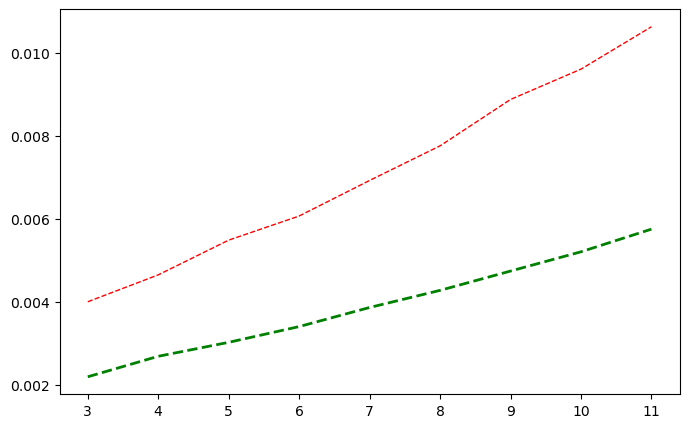

In [33]:
# This version of the Benchmarking code uses centered averages
# DO NOT EDIT THIS CELL

import matplotlib.pyplot as plt

def centered_average(nums):
    if len(nums) < 3:
        return nums[0]

    return (sum(nums) - max(nums) - min(nums)) / (len(nums) - 2)

x = range(3, 12)
y1 = [0] * len(x)
y2 = [0] * len(x)

for i, nr_q in enumerate(x):
    secret = '1' * nr_q
    circuit_orig = bernstein_vazirani(nr_q, secret)
    circuit_opt = optimize_bv(nr_q, circuit_orig)

    tmp1 = [evaluate_circuit(circuit_orig) for i in range(10)]
    tmp2 = [evaluate_circuit(circuit_opt) for i in range(10)]

    y1[i] = centered_average(tmp1)
    y2[i] = centered_average(tmp2)

# Example from https://pythonbasics.org/matplotlib-line-chart/
plt.figure(num = 3, figsize=(8, 5))
plt.plot(x, y2, 
         color='green',   
         linewidth=2.0,  
         linestyle='--' )
plt.plot(x, y1, 
         color='red',   
         linewidth=1.0,  
         linestyle='--' 
        )

plt.show()

Please run the code above to plot.

## Tests

The following lines of code will be used to evaluate the output of the code. The outputs will not be evaluated automatically, but by visual inspection. This is to guarantee that small bugs/issues can be taken into consideration.

In [34]:
# DO NOT EDIT THIS CELL


# Correct circuits
print("***** Compiling circuits")
circuit_orig_1 = bernstein_vazirani(3, "111")
circuit_orig_2 = bernstein_vazirani(5, "00111")
# 0.5 - VISIBLE
print(circuit_orig_1)
print(circuit_orig_2)

# Optimize circuits
print("***** Optimising circuits")
circuit_opt_1 = optimize_bv(3, bernstein_vazirani(3, "111"))
circuit_opt_2 = optimize_bv(5, bernstein_vazirani(5, "00111"))
# 1.0 - VISIBLE
print(circuit_opt_1)
print(circuit_opt_2)


# Export circuits
print("***** Exporting circuits")
circuit_exp_1 = export_circuit(circuit_opt_1)
circuit_exp_2 = export_circuit(circuit_opt_2)
# General form 0.25
print(circuit_exp_1)
# How many T gates? 0.25
print(len([y for y in circuit_exp_1 if y['gate']=='t']))
# A single CX? 0.25
print(len([y for y in circuit_exp_2 if y['gate']=='cx']))
# ... operating on multiple qubits? 0.25
print(len([y for y in circuit_exp_2 if len(y['qubits'])==4]))

print("***** Benchmarking circuits")
# Benchmark circuits
# 0.5
for i, val in enumerate(y1):
    # Expect True everywhere, because optimized circuit has shorter execution time
    print(val - y2[i] > 0)

***** Compiling circuits
0: ───H───@───H───────────
          │
1: ───H───┼───@───H───────
          │   │
2: ───H───┼───┼───@───H───
          │   │   │
3: ───H───X───X───X───H───
0: ───H───H───────────────

1: ───H───H───────────────

2: ───H───@───H───────────
          │
3: ───H───┼───@───H───────
          │   │
4: ───H───┼───┼───@───H───
          │   │   │
5: ───H───X───X───X───H───
***** Optimising circuits
0: ───X───
      │
1: ───X───
      │
2: ───X───
      │
3: ───@───
2: ───X───
      │
3: ───X───
      │
4: ───X───
      │
5: ───@───
***** Exporting circuits
[{'gate': 'cx', 'qubits': [3, 0]}, {'gate': 'cx', 'qubits': [3, 1]}, {'gate': 'cx', 'qubits': [3, 2]}]
0
3
0
***** Benchmarking circuits
True
True
True
True
True
True
True
True
True


Please run the tests above to test your code. Refer to the comments as guidance on what you should be seeing.